# Imports

In [1]:
# pyright: reportUnknownArgumentType=false, reportCallIssue=false, reportAttributeAccessIssue=false, reportOptionalSubscript=false, reportArgumentType=false
from rich.console import Console
from rich.table import Table
from rich.theme import Theme

from finesse.model import Model
from finesse.analysis.actions.axes import Noxaxis, Xaxis
from finesse.solutions import SeriesSolution
from finesse.detectors import PowerDetector
from finesse.analysis.actions import (
    TemporaryParameters,
    Change,
    Maximize,
    Minimize,
    Series,
    FrequencyResponse,
)
from finesse.components import Mirror, SignalGenerator
from finesse.detectors import QuantumNoiseDetector
from finesse.detectors.camera import CCD

from pathlib import Path
from typing import NamedTuple
import re

from matplotlib.axes import Axes
from matplotlib.pyplot import figure, show

from numpy import linspace, geomspace, angle, diff, loadtxt, load, zeros

In [2]:
from gettext import install
from logging import getLogger

In [3]:
install(__name__)
logger = getLogger(__name__)
theme = Theme(
    {
        "strong": "cyan underline",
        "result": "red bold",
    }
)
console = Console(theme=theme)

In [4]:
class Mode(NamedTuple):
    CCD: CCD
    PD: PowerDetector
    mode: list[int]

## Paramètres généraux

In [5]:
C_POWER = 25  # en Whatt
C_DARK_FRINGE = 8e-3  # en Whatt
C_PRECISION = 500  # number of points in simulation
C_SR_ANGLE = 2e-6

## Modèle simplifié de Virgo

/home/demagny/codes/python/finesse/finesse-simulation-04/.venv/lib/python3.13/site-packages/pygraphviz/agraph.py:1403: RuntimeWarning: Warning: Illegal value sgd for attribute "mode" in graph  - ignored

  warnings.warn(b"".join(errors).decode(self.encoding), RuntimeWarning)


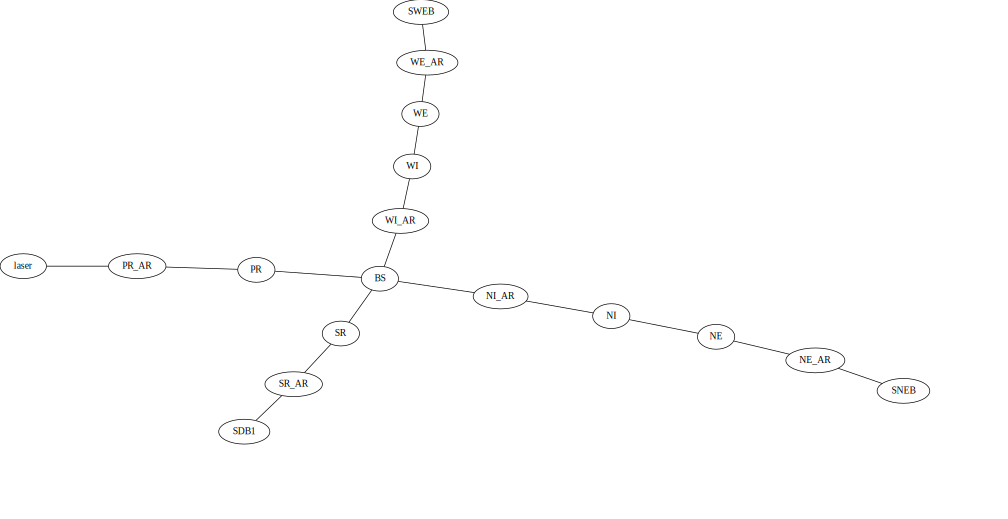

In [6]:
%matplotlib ipympl
model_file = Path("model.kat")
model = Model()
model.phase_config(zero_k00=False, zero_tem00_gouy=True)
# model.modes(modes="off")
model.parse(model_file.read_text())
model.lambda0 = model.get("wavelength")
model.SR.xbeta = C_SR_ANGLE  # yaw rotation of SR
model.laser.P = C_POWER
model.plot_graph()  # pyright: ignore[reportUnusedCallResult]
show()

In [8]:
from finesse.parameter import float_parameter
from finesse.components.general import borrows_nodes

from finesse.components.readout import ReadoutDC
from finesse.detectors.general import MaskedDetector

model.phase_config(zero_k00=False, zero_tem00_gouy=True)
model.modes(maxtem=3)  # pyright: ignore[reportUnusedCallResult]

@borrows_nodes()
@float_parameter("f", "Frequency")
@float_parameter("phase", "Phase")
class MaskedReadoutDC(ReadoutDC, MaskedDetector):

    def __init__(
        self,
        name,
        optical_node=None,
        *,
        output_detectors=False,
        pdtype=None,
    ):
        super().__init__(
            name,
            optical_node,
            output_detectors=output_detectors,
            pdtype=pdtype,
        )
        MaskedDetector.__init__(self, name)

    @property
    def has_mask(self):
        return len(self.mask)

model.add(
    MaskedReadoutDC(
        "B1",
        output_detectors=True,
        optical_node=model.SDB1.p2.o,
    )
)

model.B1.select_mask(exclude="00")

In [9]:
result = model.run(
    TemporaryParameters(
        Series(
            Change(
                {
                    "SR.misaligned": True,
                    "PR.misaligned": True,
                }
            ),
            Maximize(
                model.get("NE_p1"),
                model.get("NORTH_ARM.DC"),
                bounds=[-180, 180],
                tol=1e-14,
            ),
            Maximize(
                model.get("WE_p1"),
                model.get("WEST_ARM.DC"),
                bounds=[-180, 180],
                tol=1e-14,
            ),
            Minimize(
                model.get("SR_p2"), model.get("MICH.DC"), bounds=[-180, 180], tol=1e-14
            ),
            Change(
                {
                    "PR.misaligned": False,
                }
            ),
            Maximize(
                model.get("PR_p2"), model.get("PRCL.DC"), bounds=[-180, 180], tol=1e-14
            ),
            Change(
                {
                    "SR.misaligned": False,
                }
            ),
            Maximize(
                model.get("B1_DC"), model.get("SRCL.DC"), bounds=[-180, 180], tol=1e-14
            ),
            Change(
                {
                    "SRCL.DC": -90,
                },
                relative=True,
            ),
        ),
        exclude=[
            "NE.phi",
            "NI.phi",
            "WE.phi",
            "WI.phi",
            "SR.phi",
            "PR.phi",
            "NORTH_ARM.DC",
            "WEST_ARM.DC",
            "DARM.DC",
            "MICH.DC",
            "PRCL.DC",
            "SRCL.DC",
            "SR.misaligned",
        ],
    ),
)

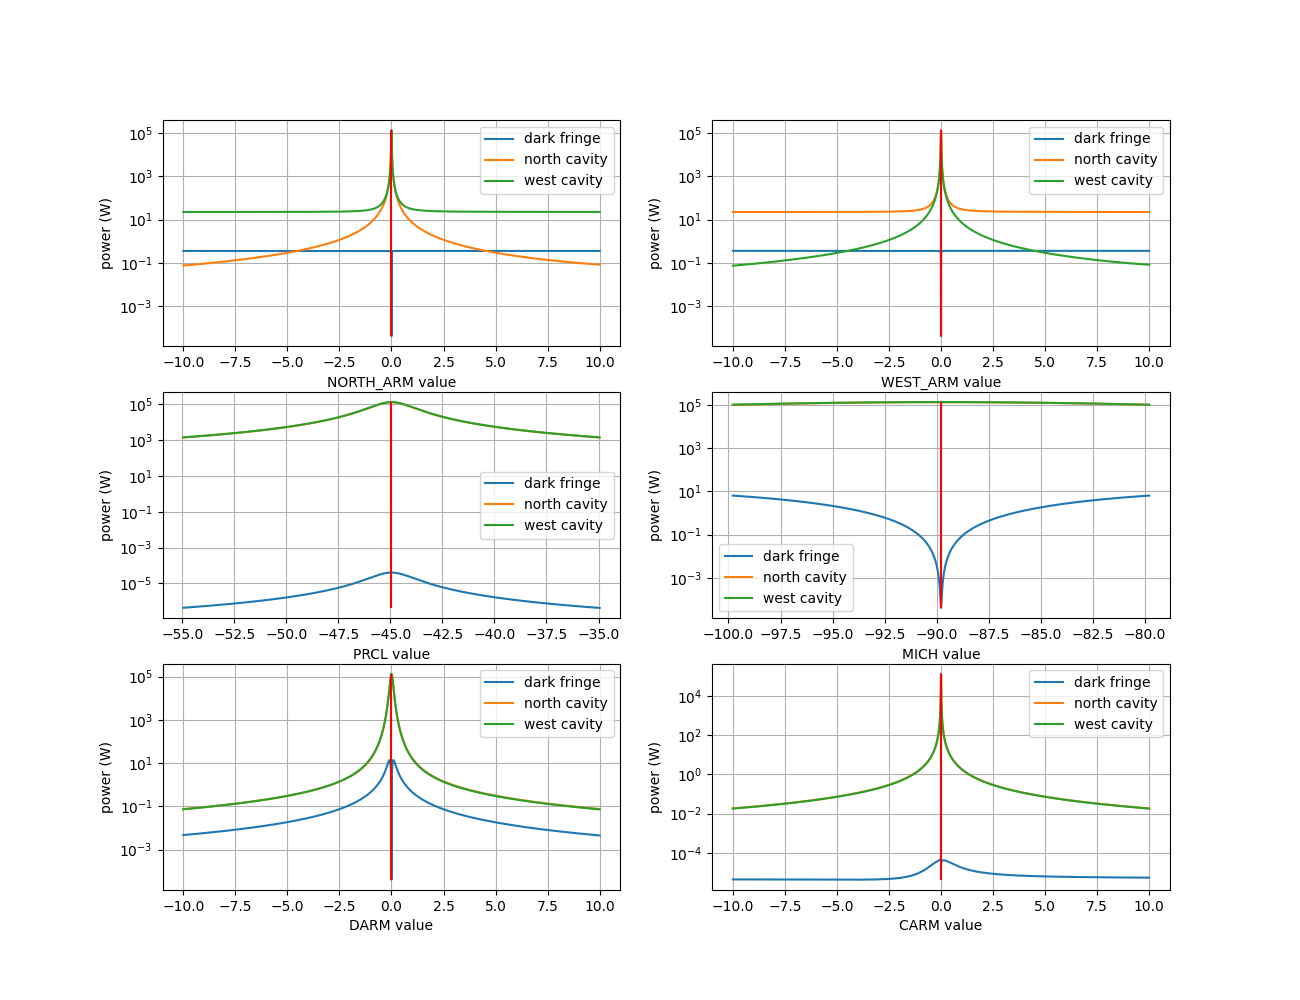

Degré de liberté 0.001373291015625 trouvé en 15 pas pour avoir une puissance de 0.008015976380943762 W sur B1

In [10]:
def compute_solutions(
    model: Model, DOF: str, padding: float, nb: int = 10000
) -> SeriesSolution:
    return model.run(
        Xaxis(
            model.get(DOF).DC,
            "lin",
            model.get(DOF).DC - padding,
            model.get(DOF).DC + padding,
            nb,
        )
    )


def display_ax(
    ax: Axes,
    solution: SeriesSolution,
    model: Model,
    DOF: str,
    padding: float,
    nb: int = 1000,
) -> Axes:
    x = linspace(model.get(DOF).DC - padding, model.get(DOF).DC + padding, nb + 1)
    _ = ax.semilogy(x, solution["SR_p2"], label="dark fringe")
    _ = ax.semilogy(x, solution["NE_p1"], label="north cavity")
    _ = ax.semilogy(x, solution["WE_p1"], label="west cavity")
    _ = ax.vlines(
        [model.get(DOF).DC],
        min(solution["SR_p2"]),
        max(solution["NE_p1"]),
        colors="red",
    )
    _ = ax.set_ylabel("power (W)")
    ax.grid()
    _ = ax.legend()
    return ax


class DisplayData(NamedTuple):
    DOF: str
    padding: float


data: list[DisplayData] = [
    DisplayData("NORTH_ARM", 10),
    DisplayData("WEST_ARM", 10),
    DisplayData("PRCL", 10),
    DisplayData("MICH", 10),
    DisplayData("DARM", 10),
    DisplayData("CARM", 10),
]

Figure = figure(figsize=(13, 10))
nb = int(1e4)

for i in range(len(data)):
    element: DisplayData = data[i]
    ax = Figure.add_subplot(3, 2, i + 1)
    solution = compute_solutions(model, element.DOF, element.padding, nb)
    _ = display_ax(ax, solution, model, element.DOF, element.padding, nb).set_xlabel(
        "{} value".format(element.DOF)
    )
show()

solution = model.run(Noxaxis())
result = solution["B1_DC"]
start, stop, nb = 0, 1, 0
while (abs(result - C_DARK_FRINGE) > 1e-4) and (nb < 100):
    nb += 1
    temp = start + (stop - start) / 2

    model.DARM.DC = temp
    solution = model.run(Noxaxis())
    result = solution["B1_DC"]
    if result > C_DARK_FRINGE:
        stop = temp
    else:
        start = temp
console.print(
    "Degré de liberté [result]{dof}[/result] trouvé en [strong]{nb} pas[/strong] pour avoir une puissance de [result]{result} W[/result] sur B1".format(
        nb=nb, dof=model.DARM.DC, result=result
    )
)

In [11]:
solution = model.run(Noxaxis())
console = Console()
table = Table(title="Puissances dans l'interferomètre")
table.add_column("position", justify="left", style="white")
table.add_column("puissance (W)", justify="left", style="cyan")

table.add_row("Injection", str(model.get("laser").P.eval()))
table.add_row("PR", str(solution["PR_p1"]))
table.add_row("cavité de recyclage de puissance", str(solution["PR_p2"]))
table.add_row("cavité ouest", str(solution["WE_p1"]))
table.add_row("cavité nord", str(solution["NE_p1"]))
table.add_row("frange noire", str(solution["SR_p2"]))
table.add_row("SNEB", str(solution["SNEB_DC"]))
table.add_row("SWEB", str(solution["SWEB_DC"]))
table.add_row("SDB1", str(solution["SDB1_DC"]))

console.print(table)

table = Table(title="DOF dans l'interferomètre")
table.add_column("nom", justify="left", style="white")
table.add_column("valeur", justify="left", style="magenta")

table.add_row("Bras nord", str(model.get("NORTH_ARM.DC")))
table.add_row("Bras ouest", str(model.get("WEST_ARM.DC")))
table.add_row("PR", str(model.get("PRCL.DC")))
table.add_row("SR", str(model.get("SRCL.DC")))
table.add_row("MICH", str(model.get("MICH.DC")))

console.print(table)

console = Console(theme=theme)
table = Table(title="")
table.add_column("nom", justify="left", style="white")
table.add_column("valeur", justify="left", style="cyan")
for i in range(1, model.west_arm.info_parameter_table().table.shape[0]):
    table.add_row(
        str(model.west_arm.info_parameter_table().table[i, 0]),
        str(model.west_arm.info_parameter_table().table[i, 1]),
    )
console.print(table)

             Puissances dans l'interferomètre              
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ position                         ┃ puissance (W)        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ Injection                        │ 25.0                 │
│ PR                               │ 3.526957366614824    │
│ cavité de recyclage de puissance │ 965.2142298520064    │
│ cavité ouest                     │ 135235.08056145057   │
│ cavité nord                      │ 133170.67341367877   │
│ frange noire                     │ 0.012628969903008597 │
│ SNEB                             │ 0.597728289582246    │
│ SWEB                             │ 0.5814405064380573   │
│ SDB1                             │ 0.012627189218252274 │
└──────────────────────────────────┴──────────────────────┘

       DOF dans l'interferomètre       
┏━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ nom        ┃ valeur                 ┃
┡━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Bras nord  │ 6.715714902384208e-06  │
│ Bras ouest │ -5.857297778129577e-05 │
│ PR         │ -44.94668032979971     │
│ SR         │ -135.14725573725798    │
│ MICH       │ -89.79031939744974     │
└────────────┴────────────────────────┘

┏━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ nom                   ┃ valeur                          ┃
┡━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ FSR                   │ 49968.74091606107               │
│ Loss                  │ 0.013848722846499961            │
│ Finesse               │ 450.5516190359727               │
│ FWHM                  │ 110.90569605093683              │
│ Storage time          │ 0.0028700950223295757           │
│ Pole                  │ 55.45284802546841               │
│ Round trip length     │ 5999.6                          │
│ Waist size            │ [0.00968668 0.00968668]         │
│ Waist position        │ [-1363.71492094 -1363.71492094] │
│ Stability (m-factor)  │ [0.7409226 0.7409226]           │
│ Stability (g-factor)  │ [0.8704613 0.8704613]           │
│ Round trip gouy phase │ [317.81006617 317.81006617]     │
│ Mode separation       │ [5856.04964666 5856.04964666]   │
│ Resolution            │ [52.80206387 52.80206387]       │
│ Stable                │ True                            │
│ Critically stable     │ False                           │
└───────────────────────┴─────────────────────────────────┘

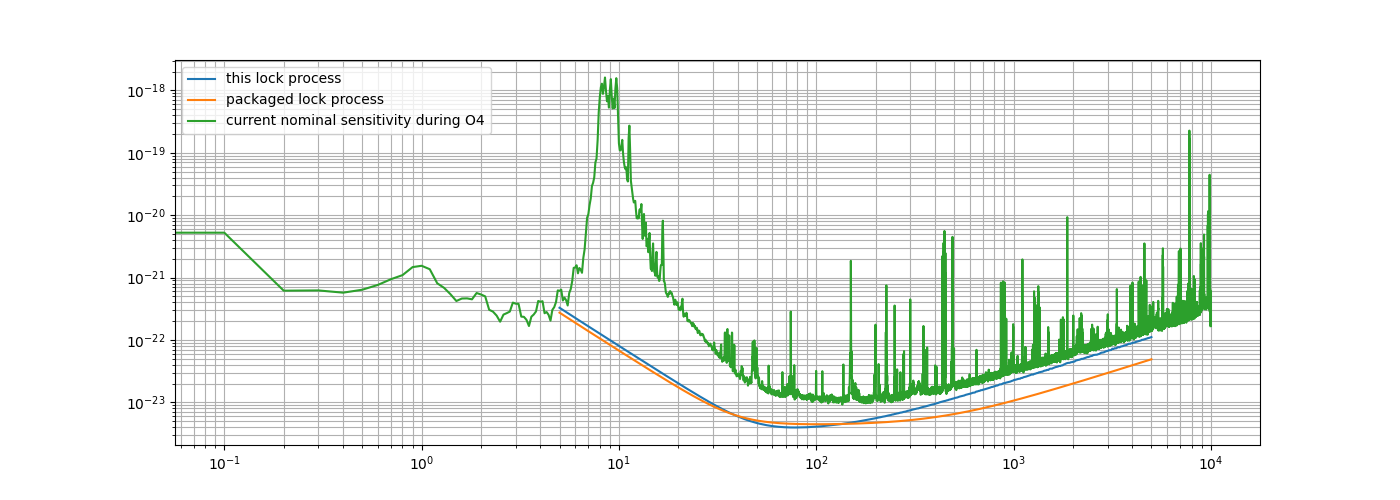

<SignalNode B1.DC.o @ 0x7ed04247fee0>

KeyError: 'B1.DC.o'

In [18]:
def get_QNLS(
    model: Model, start: int = 5, stop: int = 1000, nb: int = 100
) -> SeriesSolution:
    new_model = model.deepcopy()
    new_model.fsig.f = 1
    new_model.add(SignalGenerator("darmx", new_model.space_NI_NE.h, 1, 0))
    new_model.add(SignalGenerator("darmy", new_model.space_WI_WE.h, 1, 180))
    new_model.add(QuantumNoiseDetector("NSR_with_RP", new_model.SR.p2.o, True))
    return new_model.run(Xaxis(new_model.get("fsig.f"), "log", start, stop, nb))


model._settings.phase_config.zero_k00 = False

solution = get_QNLS(model, 5, 5000, C_PRECISION)


def dumb_parse(value: str = ""):
    regex = re.compile("\\((\\d+\\.\\d+e[+-]\\d{2})([+-]\\d+\\.\\d+e[+-]\\d{2})j\\)")
    result = re.search(regex, value)
    if result:
        return float(result.groups()[0]) + 1j * float(result.groups()[1])
    raise Exception(value)


QNLS = load("sensitivities/finesse-virgo.npy")
current_O4_sensitivity_ASD = loadtxt("sensitivities/O4_nominal_reference.txt")

Figure = figure(figsize=(14, 5))
_ = Figure.gca().loglog(
    solution.x1, abs(solution["NSR_with_RP"]), label="this lock process"
)
_ = Figure.gca().loglog(
    QNLS[0],
    QNLS[1],
    label="packaged lock process",
)
_ = Figure.gca().loglog(
    current_O4_sensitivity_ASD[0],
    abs(current_O4_sensitivity_ASD[1]),
    label="current nominal sensitivity during O4",
)
_ = Figure.gca().legend()
Figure.gca().grid(True, "both", "both")
show()

console.print(model.B1.DC.o)

solution = model.run(
    FrequencyResponse(geomspace(5, 10000, C_PRECISION), ["DARM"], ["B1.DC"])
)
maximum_amplitude_step: float = max(abs(diff(angle(solution["B1.DC", "DARM"]))))
"""
pole_index = round(
    mean(
        where(
            abs(angle(solution["B1.I", "DARM"]) + pi / 4) < maximum_amplitude_step * 2
        )
    )
)  # find the index where the curve is the closest to -45°
console.print(
    "Le [strong]pôle[/strong] de la fonction de transfert [strong]DARM[/strong] est à [result]{:.1f}[/result] Hz".format(
        solution.f[pole_index]
    )
)
"""

table = Table(title="Position des différents miroirs")
table.add_column("miroir", justify="left", style="white")
table.add_column("offset (°)", justify="left", style="white")
table.add_column("offset (m)", justify="left", style="white")

for name in [
    "NE",
    "NE_AR",
    "NI",
    "NI_AR",
    "WE",
    "WE_AR",
    "WI",
    "WI_AR",
    "PR",
    "PR_AR",
    "SR",
    "SR_AR",
]:
    element: Mirror = model.get(name)
    table.add_row(
        str(element.name),
        str(element.phi.eval()),
        str(element.phi.eval() * model.lambda0 / 180),
    )

console.print(table)

## Observation des modes d'ordres supérieurs

In [ ]:
modes: list[Mode] = []
for mode_int in model.modes():
    name_PD = "B1_power_{}_{}".format(*mode_int)
    name_CCD = "B1_CCD_{}_{}".format(*mode_int)
    temp_mode = Mode(
        CCD=model.add(CCD(name_CCD, model.SDB1.p2.o, 3, 3, 1000)),
        PD=model.add(PowerDetector(name_PD, model.SDB1.p2.o)),
        mode=list(mode_int),
    )
    temp_modes = [list(mode) for mode in model.modes()]
    temp_modes.remove(list(temp_mode.mode))
    temp_mode.CCD.select_mask(temp_modes)
    temp_mode.PD.select_mask(temp_modes)
    modes.append(temp_mode)
    
result = model.run(Noxaxis())

In [ ]:
table = Table()
table.add_column("Mode")
table.add_column("Power (W)")

outputs: list[str] = []
for mode in modes:
    table.add_row("{}, {}".format(*mode.mode), "{}".format(result[mode.PD.name]))

console.print(table)

In [ ]:
result.plot()
show()

In [ ]:
image = zeros(result[modes[0].CCD.name].shape)
for mode in modes:
    image += result[mode.CCD.name]
Figure = figure(figsize=(7, 7))
mappable = Figure.gca().imshow(image)
Figure.colorbar(mappable)
show()
Figure = figure(figsize=(7, 7))
mappable = Figure.gca().imshow(result[modes[0].CCD.name])
Figure.colorbar(mappable)
show()
Figure = figure(figsize=(7, 7))
mappable = Figure.gca().imshow(result[modes[5].CCD.name])
Figure.colorbar(mappable)
show()
Figure = figure(figsize=(7, 7))
mappable = Figure.gca().imshow(result[modes[1].CCD.name])
Figure.colorbar(mappable)
show()